# Data Exploration
1. Import data to this notebook
2. Explore data


In [1]:
# import necessary libraries for this explorarion process
import os
import pandas as pd
import numpy as np
import dask
import dask_image.imread
import dask.array as da
import dask.dataframe as dd
import cv2
import napari
import matplotlib.pyplot as plt
import seaborn as sns
from distributed import Client, LocalCluster

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'analysis-modelling.ipynb',
 'dask-worker-space',
 'plant-pathology-2021-fgvc8.zip',
 'pull-data-from-kaggle.ipynb',
 'sample_submission.csv',
 'test_images',
 'test_modified_images',
 'train.csv',
 'train_images',
 'train_images_array_form.csv',
 'train_modified_images']

In [3]:
metadata_train_ori = pd.read_csv("train.csv")
metadata_train = metadata_train_ori.copy()
display(metadata_train.head())
# the data itself has 18632 row and 2 Columns
# which can be summarized that there is a 18632 images to loaded for training
display(metadata_train.info())

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18632 entries, 0 to 18631
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   18632 non-null  object
 1   labels  18632 non-null  object
dtypes: object(2)
memory usage: 291.2+ KB


None

'There are 18632 image(s) and 12 labels.'

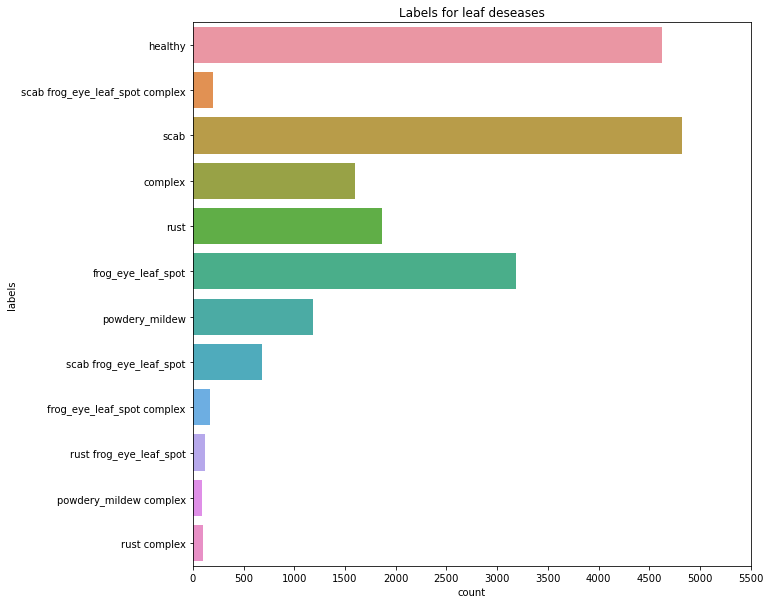

In [4]:
#check for unique variable
unique_train = metadata_train.nunique()
display(f"There are {unique_train.image} {metadata_train.columns[0]}(s) and {unique_train.labels} {metadata_train.columns[1]}.")
unique_label_count = metadata_train['labels'].value_counts()

#show how many labels in the dataframe
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(data=metadata_train, ax=ax, y="labels")
ax.set_title("Labels for leaf deseases")
ax.set_xticks(range(0,6000, 500))

In [6]:
def get_full_dir_image():
    arr = []
    for (root, dirs, files) in os.walk("train_images"):
        for filename in files:
            arr.append(os.path.join(root, filename))
    return arr


In [7]:
metadata_train['image'] = get_full_dir_image()

In [8]:
metadata_train.head()

,image,labels
0,train_images\800113bb65efe69e.jpg,healthy
1,train_images\8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,train_images\80070f7fb5e2ccaa.jpg,scab
3,train_images\80077517781fb94f.jpg,scab
4,train_images\800cbf0ff87721f8.jpg,complex


# Explore Image using Napari
napari is a fast, interactive, multi-dimensional image viewer for Python. It’s designed for browsing, annotating, and analyzing large multi-dimensional images. It’s built on top of Qt (for the GUI), vispy (for performant GPU-based rendering), and the scientific Python stack (numpy, scipy)(source: https://napari.org/)

In [10]:
# using dask_image to read images data into dask array
images_in_dask = dask_image.imread.imread('original_images/train_images/*.jpg')

C:\Users\USER\Anaconda3\lib\site-packages\pims\api.py:207: UserWarning: <class 'pims.image_reader.ImageReader'> errored: No such file: 'C:\Users\USER\Documents\DATA USER\DATA D\KULIAH UPH semester 7\Kecerdasan Komputasional\Project\original_images\train_images\*.jpg'
  warn(message)
C:\Users\USER\Anaconda3\lib\site-packages\pims\api.py:207: UserWarning: <class 'pims.image_reader.ImageReaderND'> errored: No such file: 'C:\Users\USER\Documents\DATA USER\DATA D\KULIAH UPH semester 7\Kecerdasan Komputasional\Project\original_images\train_images\*.jpg'
  warn(message)
C:\Users\USER\Anaconda3\lib\site-packages\pims\api.py:207: UserWarning: <class 'pims.imageio_reader.ImageIOReader'> errored: The ImageIOReader requires imageio and (for imageio >= 2.5) imageio-ffmpeg to work.
  warn(message)
C:\Users\USER\Anaconda3\lib\site-packages\pims\api.py:207: UserWarning: <class 'pims.bioformats.BioformatsReader'> errored: The file "original_images/train_images/*.jpg" does not exist.
  warn(message)


UnknownFormatError: All handlers returned exceptions:
<class 'pims.image_reader.ImageReader'> errored: No such file: 'C:\Users\USER\Documents\DATA USER\DATA D\KULIAH UPH semester 7\Kecerdasan Komputasional\Project\original_images\train_images\*.jpg'
<class 'pims.image_reader.ImageReaderND'> errored: No such file: 'C:\Users\USER\Documents\DATA USER\DATA D\KULIAH UPH semester 7\Kecerdasan Komputasional\Project\original_images\train_images\*.jpg'
<class 'pims.imageio_reader.ImageIOReader'> errored: The ImageIOReader requires imageio and (for imageio >= 2.5) imageio-ffmpeg to work.
<class 'pims.bioformats.BioformatsReader'> errored: The file "original_images/train_images/*.jpg" does not exist.


In [9]:
# napari for viewing the images
viewer = napari.Viewer()
viewer.add_image(images_in_dask, contrast_limits=[0, 2000])

C:\Users\USER\Anaconda3\lib\site-packages\napari\_qt\__init__.py:54: UserWarning: 

napari was tested with QT library `>=5.12.3`.
The version installed is 5.9.7. Please report any issues with
this specific QT version at https://github.com/Napari/napari/issues.
  warn(message=warn_message)


<Image layer 'images_in_dask' at 0x239457f9b20>

# Image Preprocessing

In [9]:
#All necessecary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [10]:
# check GPU
# Return a list of physical devices visible to the host runtime.
gpu = tf.config.experimental.list_physical_devices('GPU')
print(f"there is/are {len(gpu)} GPU devices")
# Set if memory growth should be enabled for a PhysicalDevice (GPU).
tf.config.experimental.set_memory_growth(gpu[0], True)

there is/are 1 GPU devices


In [11]:
gpu

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
os.getcwd()

'C:\\Users\\USER\\Documents\\DATA USER\\DATA D\\KULIAH UPH semester 7\\Kecerdasan Komputasional\\Project'

For this experiment, we will be using GPU for computation. 

reduce size of image to 400x300 for computational efficiency

In [15]:
#specify path for files for images
train_ori_path = "train_images"
test_ori_path = "test_images"
train_modified_path = "train_modified_images"
test_modified_path = "test_modified_images"

img_data_gen = ImageDataGenerator(rescale=1./255)
train = img_data_gen.flow_from_dataframe(dataframe=metadata_train, 
                                         x_col="image", 
                                         y_col="labels",
                                         batch_size=len(metadata_train_ori),
                                         subset="training",
                                         target_size=(200,200),
                                         validate_filenames=False)


Found 18632 non-validated image filenames belonging to 12 classes.


In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [37]:
#using gpu for computation

import time
start_time = time.time()
with tf.device('/GPU:0'):
    imgs_gpu, labels_gpu = next(train)
print(f"execution time {time.time()-start_time}")

execution time 2156.715269804001


In [189]:
imgs_and_labels = {}
imgs_and_labels['labels'] = metadata_train_ori['labels'].values

# # prepare array for the each pixel in every images
# for i in range(len(imgs_gpu[0].reshape(-1))):
#     imgs_and_labels[f"pixel_{i}"] = []

In [47]:
imgs_and_labels = {
    'imgs_arr': imgs_gpu,
    'labels' : metadata_train_ori['']
}




0.7254902
0.90196085
0.6784314
0.70980394
0.8745099
0.6784314
0.7490196
0.8980393
0.7372549
0.7568628
0.8980393
0.7490196
0.7490196
0.90196085
0.7294118
0.72156864
0.8980393
0.68235296
0.67058825
0.86666673
0.5882353
0.63529414
0.8470589
0.5176471
0.6313726
0.8470589
0.52156866
0.6039216
0.81568635
0.50980395
0.6039216
0.8235295
0.5294118
0.5921569
0.8078432
0.5411765
0.5921569
0.8078432
0.5529412
0.5764706
0.7803922
0.5921569
0.54901963
0.7607844
0.61960787
0.5137255
0.7372549
0.6117647
0.5568628
0.75294125
0.6392157
0.64705884
0.80392164
0.69803923
0.6431373
0.8117648
0.7019608
0.63529414
0.8117648
0.69803923
0.5686275
0.7490196
0.63529414
0.54509807
0.7372549
0.62352943
0.54509807
0.74509805
0.67058825
0.5647059
0.7725491
0.7019608
0.5686275
0.77647066
0.7058824
0.5686275
0.77647066
0.7058824
0.5647059
0.7725491
0.69411767
0.56078434
0.7725491
0.68235296
0.5568628
0.7686275
0.6745098
0.54901963
0.7607844
0.6666667
0.56078434
0.7686275
0.6666667
0.5686275
0.77647066
0.65882355
0.5960

0.6039216
0.43529415
0.63529414
0.60784316
0.4431373
0.654902
0.6039216
0.45098042
0.6627451
0.6117647
0.44705886
0.6666667
0.6313726
0.44705886
0.6627451
0.6392157
0.43921572
0.654902
0.6313726
0.4784314
0.6862745
0.654902
0.45098042
0.65882355
0.627451
0.46274513
0.67058825
0.6392157
0.4431373
0.6666667
0.6313726
0.49803925
0.69803923
0.67058825
0.48235297
0.69411767
0.6431373
0.5137255
0.68235296
0.5764706
0.61960787
0.7607844
0.61960787
0.7176471
0.86274517
0.7019608
0.79215693
0.9294118
0.7725491
0.81568635
0.94117653
0.78823537
0.73333335
0.882353
0.7372549
0.60784316
0.77647066
0.67058825
0.5686275
0.7372549
0.65882355
0.5882353
0.7568628
0.68235296
0.5803922
0.7490196
0.68235296
0.5921569
0.76470596
0.7058824
0.62352943
0.7960785
0.74509805
0.6039216
0.7725491
0.73333335
0.59607846
0.76470596
0.7254902
0.5882353
0.7686275
0.7254902
0.57254905
0.75294125
0.7137255
0.5137255
0.7176471
0.67058825
0.50980395
0.7058824
0.65882355
0.4901961
0.6901961
0.6313726
0.47058827
0.67058825
0

0.7686275
0.6156863
0.6
0.76470596
0.67058825
0.6392157
0.8196079
0.6784314
0.76470596
0.89019614
0.7294118
0.8000001
0.909804
0.7490196
0.79215693
0.90196085
0.74509805
0.8313726
0.9294118
0.8117648
0.83921576
0.9333334
0.83921576
0.8470589
0.94117653
0.87843144
0.8235295
0.93725497
0.86666673
0.76470596
0.91372555
0.8235295
0.7294118
0.8941177
0.8078432
0.70980394
0.882353
0.77647066
0.7019608
0.8745099
0.7686275
0.67058825
0.8431373
0.7372549
0.67058825
0.85098046
0.7411765
0.64705884
0.82745105
0.6745098
0.43921572
0.63529414
0.4039216
0.30588236
0.5294118
0.227451
0.30980393
0.52156866
0.19215688
0.27450982
0.48627454
0.14901961
0.2784314
0.49803925
0.15686275
0.29411766
0.5137255
0.17254902
0.33333334
0.54509807
0.20784315
0.3137255
0.5254902
0.19607845
0.3019608
0.50980395
0.20392159
0.34509805
0.5411765
0.25490198
0.3647059
0.5529412
0.31764707
0.5411765
0.7254902
0.56078434
0.32941177
0.5176471
0.32941177
0.20784315
0.40784317
0.14509805
0.27450982
0.47450984
0.21176472
0.3725

0.6156863
0.5686275
0.7686275
0.6
0.53333336
0.7372549
0.5568628
0.50980395
0.7176471
0.5137255
0.5529412
0.7607844
0.5568628
0.60784316
0.79215693
0.5764706
0.69803923
0.8705883
0.6627451
0.7686275
0.9333334
0.7372549
0.7803922
0.9450981
0.76470596
0.73333335
0.9176471
0.7372549
0.6784314
0.87843144
0.7176471
0.6
0.81568635
0.6627451
0.5372549
0.7607844
0.5921569
0.5372549
0.7568628
0.5647059
0.5294118
0.75294125
0.5529412
0.5137255
0.72156864
0.5019608
0.50980395
0.7176471
0.5058824
0.5568628
0.75294125
0.56078434
0.57254905
0.7607844
0.6039216
0.60784316
0.7843138
0.654902
0.6117647
0.7803922
0.6627451
0.6156863
0.77647066
0.6509804
0.6117647
0.7725491
0.64705884
0.5921569
0.76470596
0.62352943
0.60784316
0.7843138
0.6313726
0.57254905
0.7490196
0.5882353
0.5764706
0.7411765
0.58431375
0.5803922
0.7411765
0.58431375
0.58431375
0.74509805
0.5882353
0.5647059
0.7294118
0.5803922
0.5372549
0.70980394
0.5686275
0.5176471
0.6901961
0.54901963
0.4901961
0.6666667
0.5372549
0.5058824
0.690

0.21568629
0.17254902
0.69411767
0.8745099
0.76470596
0.62352943
0.8352942
0.74509805
0.5764706
0.78823537
0.69803923
0.54509807
0.7568628
0.6666667
0.5568628
0.7686275
0.6784314
0.5529412
0.7568628
0.67058825
0.5647059
0.75294125
0.65882355
0.5411765
0.7372549
0.6
0.5411765
0.7490196
0.54509807
0.5254902
0.7254902
0.49411768
0.5058824
0.7176471
0.47450984
0.49411768
0.7058824
0.46274513
0.49411768
0.7058824
0.4784314
0.48627454
0.69411767
0.48235297
0.4784314
0.6862745
0.47450984
0.45882356
0.6666667
0.454902
0.5058824
0.7019608
0.5019608
0.5294118
0.7254902
0.49411768
0.5254902
0.72156864
0.48235297
0.49803925
0.69803923
0.43921572
0.47058827
0.67058825
0.40000004
0.5568628
0.7607844
0.4784314
0.6862745
0.86666673
0.58431375
0.7490196
0.9058824
0.65882355
0.8313726
0.9686275
0.7490196
0.8431373
0.9725491
0.80392164
0.8352942
0.9843138
0.8235295
0.8352942
0.9803922
0.85098046
0.8313726
0.9803922
0.8980393
0.8431373
0.96470594
0.94117653
0.854902
0.97647065
0.9450981
0.86274517
0.96862

0.46274513
0.44705886
0.48627454
0.45098042
0.48235297
0.53333336
0.49411768
0.59607846
0.7803922
0.7019608
0.5882353
0.7803922
0.6627451
0.54509807
0.7411765
0.5921569
0.5137255
0.72156864
0.5019608
0.49803925
0.7137255
0.45098042
0.5058824
0.70980394
0.4666667
0.5137255
0.7137255
0.48235297
0.5568628
0.7490196
0.57254905
0.6039216
0.7843138
0.67058825
0.6313726
0.8078432
0.7176471
0.6313726
0.8078432
0.7254902
0.57254905
0.7607844
0.6666667
0.5294118
0.7411765
0.6156863
0.48627454
0.69803923
0.57254905
0.45882356
0.6784314
0.53333336
0.4431373
0.65882355
0.5019608
0.61960787
0.78823537
0.6117647
0.74509805
0.909804
0.7137255
0.8470589
0.9568628
0.8000001
0.82745105
0.95294124
0.79215693
0.76470596
0.91372555
0.75294125
0.61960787
0.81568635
0.6156863
0.5176471
0.72156864
0.4784314
0.56078434
0.76470596
0.5137255
0.60784316
0.8000001
0.5411765
0.63529414
0.8313726
0.56078434
0.6431373
0.83921576
0.5529412
0.6784314
0.8588236
0.5764706
0.7372549
0.9058824
0.63529414
0.7607844
0.9137255

0.5137255
0.20784315
0.2509804
0.47450984
0.17254902
0.29411766
0.5058824
0.21176472
0.25490198
0.4666667
0.16078432
0.24705884
0.45882356
0.15294118
0.25882354
0.47450984
0.15686275
0.24313727
0.4666667
0.14901961
0.24313727
0.4666667
0.14901961
0.30980393
0.53333336
0.22352943
0.2509804
0.47450984
0.17254902
0.23137257
0.454902
0.15294118
0.26666668
0.4901961
0.18823531
0.23137257
0.4431373
0.14509805
0.20000002
0.41176474
0.1137255
0.2392157
0.45882356
0.17254902
0.25490198
0.4666667
0.17254902
0.2627451
0.48235297
0.19607845
0.3137255
0.52156866
0.24705884
0.24313727
0.46274513
0.18431373
0.23137257
0.43921572
0.16470589
0.20392159
0.42352945
0.13725491
0.32156864
0.5294118
0.24705884
0.2509804
0.45882356
0.1764706
0.21568629
0.42352945
0.14117648
0.22352943
0.43137258
0.14901961
0.20784315
0.4156863
0.13333334
0.25490198
0.454902
0.18431373
0.24313727
0.4431373
0.18039216
0.36862746
0.5686275
0.30588236
0.21176472
0.41176474
0.14901961
0.20784315
0.40784317
0.13725491
0.28235295
0

0.41176474
0.2509804
0.2627451
0.41176474
0.2509804
0.28235295
0.41176474
0.29803923
0.32941177
0.40784317
0.30980393
0.31764707
0.39607847
0.29803923
0.27450982
0.40784317
0.27058825
0.23137257
0.3921569
0.227451
0.33333334
0.47450984
0.33333334
0.3647059
0.52156866
0.38823533
0.43137258
0.56078434
0.37647063
0.4431373
0.54509807
0.43921572
0.46274513
0.5647059
0.4666667
0.5137255
0.60784316
0.5058824
0.46274513
0.5568628
0.42352945
0.40784317
0.49803925
0.3254902
0.45882356
0.5137255
0.44705886
0.5176471
0.5764706
0.5019608
0.5058824
0.57254905
0.50980395
0.45882356
0.5372549
0.43137258
0.41960788
0.5254902
0.4039216
0.4039216
0.52156866
0.38823533
0.36078432
0.48627454
0.34117648
0.30588236
0.43137258
0.28627452
0.76470596
0.81568635
0.83921576
0.7568628
0.8078432
0.83921576
0.7254902
0.7803922
0.7803922
0.6862745
0.74509805
0.73333335
0.72156864
0.7803922
0.7607844
0.7176471
0.77647066
0.7568628
0.6745098
0.7411765
0.70980394
0.6666667
0.73333335
0.7019608
0.6901961
0.7568628
0.717

0.6901961
0.73333335
0.7411765
0.6784314
0.7254902
0.7254902
0.60784316
0.654902
0.64705884
0.60784316
0.6431373
0.6313726
0.6
0.63529414
0.6156863
0.6117647
0.64705884
0.627451
0.5882353
0.627451
0.5921569
0.5254902
0.5686275
0.5058824
0.5019608
0.54509807
0.48235297
0.50980395
0.5686275
0.49411768
0.5411765
0.6
0.5254902
0.59607846
0.6627451
0.5882353
0.6745098
0.73333335
0.6509804
0.7686275
0.8705883
0.7568628
0.79215693
0.91372555
0.79215693
0.7725491
0.9176471
0.7843138
0.7176471
0.90196085
0.72156864
0.62352943
0.8196079
0.6117647
0.43921572
0.6392157
0.36862746
0.36078432
0.5647059
0.27450982
0.427451
0.6313726
0.34901962
0.4431373
0.64705884
0.35686275
0.49803925
0.69411767
0.40784317
0.5176471
0.7294118
0.43529415
0.6
0.8196079
0.5254902
0.69803923
0.8941177
0.654902
0.74509805
0.91372555
0.7372549
0.7294118
0.8941177
0.7372549
0.69411767
0.8588236
0.7019608
0.79215693
0.9215687
0.7372549
0.8352942
0.9607844
0.81568635
0.8352942
0.95294124
0.8431373
0.7725491
0.91372555
0.8039

0.50980395
0.46274513
0.38823533
0.49803925
0.45098042
0.36862746
0.4784314
0.42352945
0.37647063
0.48627454
0.427451
0.39607847
0.5058824
0.44705886
0.3372549
0.4666667
0.3921569
0.37647063
0.50980395
0.4156863
0.3647059
0.49803925
0.40000004
0.40000004
0.54901963
0.4039216
0.40784317
0.5568628
0.41176474
0.40000004
0.54901963
0.4039216
0.40784317
0.54901963
0.40784317
0.4039216
0.5254902
0.40000004
0.34509805
0.4666667
0.34117648
0.31764707
0.4901961
0.34901962
0.427451
0.58431375
0.43921572
0.49411768
0.6156863
0.45098042
0.32156864
0.44705886
0.2627451
0.3529412
0.47058827
0.32156864
0.5647059
0.6901961
0.54509807
0.54901963
0.67058825
0.5372549
0.54901963
0.6784314
0.50980395
0.5019608
0.627451
0.4431373
0.44705886
0.58431375
0.33333334
0.4039216
0.5294118
0.28235295
0.36078432
0.48235297
0.2509804
0.37647063
0.49411768
0.2901961
0.34117648
0.454902
0.28235295
0.29803923
0.41960788
0.25882354
0.26666668
0.3921569
0.24705884
0.38431376
0.5019608
0.36078432
0.4666667
0.5764706
0.419

0.29411766
0.43137258
0.21960786
0.16470589
0.3254902
0.098039225
0.21960786
0.37254903
0.14901961
0.2509804
0.39607847
0.18431373
0.13725491
0.29803923
0.078431375
0.20000002
0.35686275
0.14901961
0.20784315
0.3647059
0.16078432
0.1764706
0.33333334
0.13725491
0.17254902
0.3254902
0.14117648
0.4666667
0.61960787
0.4431373
0.21568629
0.3921569
0.13725491
0.19215688
0.37254903
0.121568635
0.24313727
0.41960788
0.2509804
0.4784314
0.61960787
0.50980395
0.38823533
0.54509807
0.4431373
0.40000004
0.5568628
0.454902
0.3647059
0.52156866
0.41960788
0.41176474
0.5647059
0.48235297
0.41176474
0.5686275
0.4666667
0.43137258
0.5882353
0.48627454
0.4156863
0.5647059
0.47450984
0.45098042
0.5882353
0.5019608
0.48235297
0.6156863
0.50980395
0.5254902
0.6666667
0.5254902
0.5568628
0.6784314
0.5176471
0.6039216
0.7058824
0.6
0.5882353
0.69803923
0.60784316
0.62352943
0.7058824
0.6313726
0.627451
0.7176471
0.6392157
0.61960787
0.7019608
0.627451
0.60784316
0.7019608
0.60784316
0.59607846
0.7019608
0.5

0.45098042
0.6156863
0.427451
0.50980395
0.6745098
0.49411768
0.45882356
0.63529414
0.41176474
0.44705886
0.6313726
0.427451
0.4039216
0.5686275
0.37254903
0.38823533
0.54509807
0.34117648
0.37254903
0.54509807
0.3372549
0.41176474
0.57254905
0.34509805
0.45098042
0.6117647
0.3921569
0.4156863
0.58431375
0.3647059
0.45882356
0.627451
0.4156863
0.49803925
0.654902
0.44705886
0.43529415
0.6
0.41176474
0.4039216
0.5568628
0.38431376
0.3803922
0.5411765
0.36862746
0.33333334
0.5019608
0.3254902
0.3647059
0.5254902
0.3529412
0.48235297
0.627451
0.4666667
0.454902
0.5803922
0.41960788
0.38431376
0.4901961
0.3529412
0.41960788
0.50980395
0.39607847
0.40784317
0.49803925
0.38823533
0.47450984
0.57254905
0.44705886
0.4784314
0.6392157
0.47450984
0.5019608
0.6509804
0.5058824
0.46274513
0.60784316
0.48627454
0.38823533
0.5294118
0.427451
0.427451
0.57254905
0.45098042
0.52156866
0.6627451
0.56078434
0.43529415
0.5803922
0.44705886
0.42352945
0.56078434
0.43137258
0.4156863
0.5647059
0.41176474
0

0.67058825
0.6627451
0.5686275
0.6156863
0.60784316
0.53333336
0.5686275
0.5568628
0.49803925
0.53333336
0.5137255
0.5176471
0.5529412
0.53333336
0.4784314
0.5176471
0.48627454
0.5568628
0.59607846
0.5529412
0.454902
0.50980395
0.4431373
0.53333336
0.59607846
0.54509807
0.65882355
0.7254902
0.6862745
0.6392157
0.72156864
0.6627451
0.63529414
0.7176471
0.65882355
0.6745098
0.7568628
0.6901961
0.7058824
0.7803922
0.7019608
0.7176471
0.8000001
0.73333335
0.7019608
0.7843138
0.7254902
0.6509804
0.7294118
0.69411767
0.5764706
0.6431373
0.61960787
0.46274513
0.53333336
0.4784314
0.41960788
0.49411768
0.41960788
0.39607847
0.47058827
0.38431376
0.39607847
0.47450984
0.37647063
0.40784317
0.47058827
0.35686275
0.44705886
0.5882353
0.4156863
0.3372549
0.5176471
0.23529413
0.39607847
0.5921569
0.24313727
0.41176474
0.60784316
0.26666668
0.34117648
0.54509807
0.21960786
0.34901962
0.54901963
0.2392157
0.3137255
0.5019608
0.21176472
0.30588236
0.50980395
0.1764706
0.3372549
0.53333336
0.24705884
0

0.52156866
0.40784317
0.2784314
0.44705886
0.34117648
0.37647063
0.54509807
0.427451
0.43529415
0.58431375
0.5254902
0.37647063
0.54901963
0.48235297
0.33333334
0.5058824
0.43921572
0.36862746
0.5372549
0.47058827
0.40784317
0.5764706
0.5019608
0.33333334
0.49411768
0.42352945
0.29803923
0.4666667
0.38823533
0.3137255
0.48235297
0.4039216
0.36078432
0.5294118
0.45098042
0.3254902
0.5019608
0.41960788
0.3529412
0.5294118
0.45098042
0.38431376
0.56078434
0.48235297
0.40000004
0.5686275
0.49411768
0.5803922
0.7019608
0.6431373
0.6431373
0.72156864
0.6862745
0.61960787
0.69803923
0.6627451
0.6431373
0.70980394
0.6862745
0.6666667
0.7254902
0.7058824
0.6784314
0.7294118
0.7019608
0.65882355
0.70980394
0.68235296
0.61960787
0.68235296
0.6392157
0.58431375
0.64705884
0.6039216
0.5921569
0.654902
0.6117647
0.5921569
0.6627451
0.6156863
0.5686275
0.6392157
0.5921569
0.56078434
0.6431373
0.58431375
0.5882353
0.6666667
0.62352943
0.6
0.6862745
0.6392157
0.6156863
0.7019608
0.654902
0.63529414
0.7

0.53333336
0.43529415
0.6313726
0.58431375
0.427451
0.627451
0.6
0.4784314
0.6862745
0.6627451
0.41176474
0.61960787
0.59607846
0.36078432
0.54509807
0.4666667
0.30588236
0.48627454
0.37647063
0.45098042
0.62352943
0.5176471
0.36862746
0.54509807
0.4156863
0.45098042
0.62352943
0.48235297
0.38823533
0.5568628
0.38823533
0.41176474
0.5764706
0.39607847
0.36078432
0.5058824
0.33333334
0.38823533
0.5372549
0.34509805
0.4039216
0.54509807
0.35686275
0.45098042
0.58431375
0.38431376
0.40784317
0.54509807
0.3254902
0.3921569
0.5411765
0.31764707
0.41176474
0.56078434
0.36078432
0.47058827
0.6392157
0.45882356
0.47450984
0.6392157
0.54509807
0.40000004
0.5647059
0.48627454
0.37254903
0.5372549
0.45098042
0.36862746
0.5372549
0.43137258
0.34117648
0.50980395
0.4039216
0.36862746
0.5372549
0.43137258
0.38431376
0.5529412
0.44705886
0.3647059
0.5294118
0.4431373
0.34117648
0.5137255
0.40784317
0.32941177
0.5058824
0.3921569
0.3254902
0.48235297
0.37647063
0.3529412
0.52156866
0.41176474
0.317647

0.53333336
0.46274513
0.63529414
0.54509807
0.48627454
0.6509804
0.5647059
0.5254902
0.6784314
0.59607846
0.5254902
0.64705884
0.58431375
0.5921569
0.67058825
0.62352943
0.6039216
0.6666667
0.62352943
0.58431375
0.63529414
0.59607846
0.5372549
0.6
0.54901963
0.41176474
0.5411765
0.4666667
0.3529412
0.52156866
0.4431373
0.3647059
0.5294118
0.45098042
0.38431376
0.54901963
0.47058827
0.40784317
0.56078434
0.4784314
0.38823533
0.54509807
0.45098042
0.41176474
0.5686275
0.4666667
0.41960788
0.5764706
0.47058827
0.40000004
0.56078434
0.4431373
0.38431376
0.54509807
0.41960788
0.36078432
0.53333336
0.39607847
0.38823533
0.54901963
0.43137258
0.45098042
0.5803922
0.5137255
0.5372549
0.61960787
0.58431375
0.5764706
0.63529414
0.60784316
0.59607846
0.63529414
0.6039216
0.5764706
0.6039216
0.57254905
0.53333336
0.5647059
0.52156866
0.48235297
0.50980395
0.44705886
0.4039216
0.43137258
0.36078432
0.41176474
0.44705886
0.37254903
0.454902
0.4901961
0.40784317
0.46274513
0.5254902
0.42352945
0.4470

0.5372549
0.38431376
0.38823533
0.53333336
0.37254903
0.4156863
0.5411765
0.39607847
0.40000004
0.5137255
0.3921569
0.38823533
0.48627454
0.36078432
0.38823533
0.49803925
0.40000004
0.43137258
0.57254905
0.47058827
0.45098042
0.62352943
0.49411768
0.4039216
0.5764706
0.43921572
0.3647059
0.52156866
0.38431376
0.3921569
0.52156866
0.40000004
0.427451
0.5176471
0.43921572
0.50980395
0.56078434
0.49411768
0.5294118
0.5686275
0.5254902
0.53333336
0.5647059
0.5058824
0.45882356
0.48627454
0.42352945
0.4039216
0.43137258
0.36078432
0.43529415
0.47058827
0.4039216
0.48627454
0.52156866
0.454902
0.5176471
0.5529412
0.48627454
0.48235297
0.5176471
0.45098042
0.4156863
0.46274513
0.38431376
0.3921569
0.43921572
0.34509805
0.3921569
0.43921572
0.34509805
0.4156863
0.4784314
0.37647063
0.45098042
0.5254902
0.40784317
0.5137255
0.59607846
0.43529415
0.4431373
0.5294118
0.3372549
0.43921572
0.5254902
0.34117648
0.43921572
0.5254902
0.33333334
0.42352945
0.49411768
0.2901961
0.29803923
0.3372549
0.20

0.30980393
0.28627452
0.4431373
0.29803923
0.30588236
0.454902
0.30980393
0.27450982
0.42352945
0.27058825
0.2509804
0.40000004
0.24705884
0.2509804
0.4039216
0.23137257
0.28235295
0.4431373
0.28627452
0.25882354
0.41176474
0.23529413
0.26666668
0.41960788
0.23529413
0.28235295
0.43137258
0.23137257
0.39607847
0.5568628
0.5019608
0.454902
0.6039216
0.56078434
0.4156863
0.5764706
0.52156866
0.40784317
0.5568628
0.5058824
0.43529415
0.58431375
0.5254902
0.3921569
0.5411765
0.48235297
0.44705886
0.6
0.5294118
0.43921572
0.5921569
0.5176471
0.42352945
0.5764706
0.5019608
0.42352945
0.5803922
0.48627454
0.35686275
0.52156866
0.43529415
0.37647063
0.5411765
0.454902
0.35686275
0.52156866
0.43529415
0.35686275
0.5254902
0.44705886
0.39607847
0.57254905
0.48235297
0.34117648
0.5176471
0.427451
0.35686275
0.54509807
0.45098042
0.3529412
0.56078434
0.45882356
0.36862746
0.5568628
0.47058827
0.36862746
0.5568628
0.47058827
0.4039216
0.5921569
0.5058824
0.34117648
0.54901963
0.44705886
0.3254902
0

0.6
0.52156866
0.3803922
0.54901963
0.47058827
0.38431376
0.54901963
0.47058827
0.3372549
0.5058824
0.39607847
0.33333334
0.5019608
0.38431376
0.3803922
0.54509807
0.4039216
0.30588236
0.47058827
0.3137255
0.26666668
0.43137258
0.28235295
0.28235295
0.44705886
0.2901961
0.23137257
0.3921569
0.227451
0.2784314
0.4431373
0.25490198
0.34509805
0.5019608
0.36862746
0.44705886
0.59607846
0.5137255
0.37254903
0.5176471
0.44705886
0.37647063
0.5294118
0.454902
0.3921569
0.54509807
0.47450984
0.41960788
0.57254905
0.5019608
0.4039216
0.5568628
0.48627454
0.3921569
0.54509807
0.47450984
0.43529415
0.5882353
0.5176471
0.4039216
0.5568628
0.48627454
0.39607847
0.54901963
0.47450984
0.3921569
0.54509807
0.47058827
0.39607847
0.54901963
0.4666667
0.4039216
0.56078434
0.45882356
0.3372549
0.5058824
0.40000004
0.36862746
0.5372549
0.43137258
0.38431376
0.5568628
0.45098042
0.39607847
0.5647059
0.454902
0.3372549
0.5137255
0.40000004
0.38823533
0.57254905
0.44705886
0.3254902
0.5372549
0.4039216
0.352

0.49411768
0.5176471
0.52156866
0.5294118
0.4431373
0.4431373
0.45098042
0.36862746
0.38431376
0.38823533
0.35686275
0.37254903
0.36862746
0.52156866
0.5529412
0.50980395
0.3254902
0.47058827
0.3019608
0.40000004
0.53333336
0.38823533
0.2901961
0.45882356
0.2784314
0.227451
0.40000004
0.20000002
0.25882354
0.43137258
0.22352943
0.3647059
0.5411765
0.3254902
0.2509804
0.427451
0.21176472
0.3647059
0.54901963
0.33333334
0.21960786
0.4039216
0.18823531
0.2784314
0.46274513
0.2509804
0.37254903
0.5568628
0.34509805
0.25882354
0.4431373
0.23137257
0.2509804
0.42352945
0.21568629
0.27058825
0.4431373
0.24313727
0.2392157
0.42352945
0.21960786
0.28235295
0.454902
0.25490198
0.3137255
0.48627454
0.29411766
0.23529413
0.4039216
0.227451
0.2901961
0.45882356
0.28235295
0.42352945
0.6
0.44705886
0.34901962
0.52156866
0.38431376
0.34901962
0.52156866
0.3921569
0.34509805
0.5176471
0.38823533
0.40784317
0.5764706
0.47058827
0.31764707
0.48627454
0.37647063
0.30588236
0.4784314
0.34901962
0.3137255


0.40784317
0.5764706
0.36862746
0.3803922
0.427451
0.41176474
0.38431376
0.43529415
0.40784317
0.3647059
0.4156863
0.3803922
0.3137255
0.35686275
0.3254902
0.33333334
0.39607847
0.3529412
0.28627452
0.35686275
0.3019608
0.29411766
0.3921569
0.30980393
0.4431373
0.62352943
0.5137255
0.427451
0.61960787
0.5019608
0.454902
0.64705884
0.52156866
0.45098042
0.6627451
0.5294118
0.45098042
0.6627451
0.5294118
0.43529415
0.64705884
0.5137255
0.4431373
0.654902
0.5137255
0.43529415
0.6509804
0.49803925
0.4784314
0.69411767
0.5372549
0.5137255
0.70980394
0.56078434
0.54509807
0.7411765
0.5921569
0.50980395
0.7254902
0.57254905
0.5254902
0.7411765
0.5882353
0.5411765
0.7568628
0.6039216
0.5058824
0.7176471
0.5764706
0.4901961
0.70980394
0.57254905
0.48235297
0.7019608
0.5568628
0.49411768
0.7176471
0.5568628
0.4666667
0.6901961
0.5294118
0.4901961
0.7137255
0.5529412
0.50980395
0.7254902
0.5686275
0.5019608
0.7176471
0.56078434
0.49411768
0.70980394
0.5529412
0.47450984
0.6901961
0.53333336
0.470

0.37254903
0.121568635
0.18039216
0.33333334
0.08627451
0.26666668
0.45098042
0.18431373
0.25490198
0.43921572
0.16470589
0.27058825
0.454902
0.17254902
0.19607845
0.3803922
0.1137255
0.20392159
0.3921569
0.10196079
0.1764706
0.37254903
0.08627451
0.20392159
0.4039216
0.10980393
0.22352943
0.42352945
0.121568635
0.4039216
0.5686275
0.2784314
0.40784317
0.5568628
0.3647059
0.25882354
0.43529415
0.18039216
0.24705884
0.41960788
0.11764707
0.5372549
0.70980394
0.40784317
0.39607847
0.5647059
0.35686275
0.3529412
0.5176471
0.32156864
0.27450982
0.44705886
0.24705884
0.19607845
0.36862746
0.1764706
0.28235295
0.45098042
0.27058825
0.4784314
0.6392157
0.48235297
0.227451
0.3921569
0.21176472
0.25490198
0.40784317
0.23137257
0.21568629
0.36078432
0.18823531
0.2509804
0.4039216
0.21960786
0.31764707
0.47058827
0.28627452
0.19607845
0.35686275
0.20000002
0.38823533
0.5529412
0.4039216
0.5137255
0.6745098
0.5411765
0.23529413
0.39607847
0.2392157
0.28235295
0.427451
0.29803923
0.38823533
0.53725

0.5411765
0.5411765
0.7725491
0.54509807
0.56078434
0.77647066
0.56078434
0.62352943
0.8117648
0.60784316
0.6666667
0.8117648
0.6509804
0.6039216
0.7490196
0.5882353
0.5058824
0.6862745
0.5058824
0.45098042
0.63529414
0.454902
0.4156863
0.6039216
0.4156863
0.40000004
0.5882353
0.3921569
0.39607847
0.5764706
0.38431376
0.38823533
0.56078434
0.36862746
0.37254903
0.5529412
0.36078432
0.35686275
0.5372549
0.34509805
0.34509805
0.53333336
0.3372549
0.34901962
0.54509807
0.3529412
0.38431376
0.57254905
0.40784317
0.3921569
0.5803922
0.4156863
0.3647059
0.5647059
0.39607847
0.36078432
0.5647059
0.37647063
0.34117648
0.54901963
0.34509805
0.34901962
0.5568628
0.3529412
0.35686275
0.5803922
0.37254903
0.37647063
0.6
0.3921569
0.36862746
0.5764706
0.37254903
0.39607847
0.5921569
0.3921569
0.41176474
0.6039216
0.41960788
0.3921569
0.5764706
0.41176474
0.45098042
0.62352943
0.48235297
0.5568628
0.7137255
0.5686275
0.6039216
0.75294125
0.6
0.60784316
0.7490196
0.6
0.58431375
0.73333335
0.57254905


0.3019608
0.49803925
0.30588236
0.2901961
0.48627454
0.29411766
0.3019608
0.49411768
0.30980393
0.35686275
0.56078434
0.3803922
0.30588236
0.49411768
0.32941177
0.3254902
0.50980395
0.3372549
0.37254903
0.56078434
0.39607847
0.34509805
0.53333336
0.37647063
0.38431376
0.5686275
0.43529415
0.38823533
0.57254905
0.44705886
0.34117648
0.52156866
0.40784317
0.34117648
0.53333336
0.4156863
0.3647059
0.54509807
0.43529415
0.37647063
0.5529412
0.43921572
0.47058827
0.64705884
0.53333336
0.32156864
0.49803925
0.36862746
0.28235295
0.4666667
0.33333334
0.49803925
0.6745098
0.54509807
0.5058824
0.6862745
0.54509807
0.49803925
0.6784314
0.5372549
0.5137255
0.69411767
0.5529412
0.49411768
0.68235296
0.5176471
0.5058824
0.69803923
0.5137255
0.5176471
0.7058824
0.5176471
0.53333336
0.72156864
0.5254902
0.5294118
0.7019608
0.49411768
0.5529412
0.72156864
0.5019608
0.5529412
0.72156864
0.5019608
0.5647059
0.73333335
0.52156866
0.5647059
0.76470596
0.54509807
0.5411765
0.7490196
0.5294118
0.5647059
0.7

0.227451
0.26666668
0.43137258
0.23529413
0.25882354
0.42352945
0.227451
0.20392159
0.37254903
0.15294118
0.21568629
0.38823533
0.15686275
0.21568629
0.40000004
0.13333334
0.20000002
0.37647063
0.121568635
0.2392157
0.40784317
0.13725491
0.20784315
0.38823533
0.10588236
0.18823531
0.36862746
0.08627451
0.20784315
0.38823533
0.10588236
0.21960786
0.40000004
0.11764707
0.20392159
0.38823533
0.10588236
0.20000002
0.38431376
0.10196079
0.20392159
0.38823533
0.121568635
0.23137257
0.41176474
0.15686275
0.2627451
0.4431373
0.18823531
0.20000002
0.3803922
0.12941177
0.21960786
0.40000004
0.14901961
0.227451
0.427451
0.16862746
0.26666668
0.454902
0.227451
0.2509804
0.43921572
0.21176472
0.2627451
0.45882356
0.21176472
0.24313727
0.43137258
0.20392159
0.18039216
0.36862746
0.1254902
0.27058825
0.48235297
0.24705884
0.2627451
0.45882356
0.21960786
0.25882354
0.45098042
0.23137257
0.31764707
0.5137255
0.28235295
0.27450982
0.4666667
0.24705884
0.27450982
0.4666667
0.2509804
0.30588236
0.49411768

0.3647059
0.36078432
0.4901961
0.3137255
0.37647063
0.46274513
0.3137255
0.40000004
0.41176474
0.30588236
0.3647059
0.36078432
0.2784314
0.33333334
0.32941177
0.24705884
0.24705884
0.25490198
0.16862746
0.1764706
0.18431373
0.098039225
0.19215688
0.22352943
0.13333334
0.28235295
0.35686275
0.2784314
0.3529412
0.48235297
0.37647063
0.34509805
0.454902
0.3647059
0.38823533
0.49803925
0.40784317
0.38823533
0.5019608
0.4156863
0.36078432
0.49411768
0.40000004
0.34901962
0.48235297
0.38823533
0.3529412
0.48627454
0.3921569
0.34901962
0.48235297
0.38823533
0.38431376
0.5137255
0.43921572
0.39607847
0.5294118
0.43529415
0.39607847
0.5294118
0.43529415
0.40000004
0.53333336
0.43529415
0.41176474
0.5254902
0.4156863
0.46274513
0.5764706
0.454902
0.56078434
0.6509804
0.5411765
0.60784316
0.6862745
0.5882353
0.6039216
0.68235296
0.58431375
0.57254905
0.6666667
0.5647059
0.5647059
0.6666667
0.5529412
0.5137255
0.61960787
0.49803925
0.40000004
0.52156866
0.38823533
0.37647063
0.5176471
0.37647063
0

0.50980395
0.5019608
0.5568628
0.4666667
0.49803925
0.54509807
0.45882356
0.45098042
0.49803925
0.4039216
0.4784314
0.5529412
0.43529415
0.5019608
0.6039216
0.45098042
0.5529412
0.6627451
0.47058827
0.54509807
0.6627451
0.4666667
0.5058824
0.654902
0.454902
0.46274513
0.627451
0.43921572
0.43921572
0.60784316
0.427451
0.4039216
0.5921569
0.4039216
0.41176474
0.5921569
0.40784317
0.40000004
0.58431375
0.4039216
0.39607847
0.5882353
0.4039216
0.3803922
0.57254905
0.38823533
0.38823533
0.58431375
0.3921569
0.40784317
0.6039216
0.4039216
0.3921569
0.6
0.39607847
0.3529412
0.56078434
0.35686275
0.3647059
0.5686275
0.37647063
0.35686275
0.56078434
0.36862746
0.4039216
0.6
0.40784317
0.43529415
0.6313726
0.43921572
0.45882356
0.654902
0.46274513
0.48627454
0.6745098
0.48627454
0.48235297
0.6666667
0.48627454
0.45882356
0.6431373
0.4784314
0.43137258
0.61960787
0.454902
0.42352945
0.62352943
0.46274513
0.42352945
0.6392157
0.47450984
0.427451
0.64705884
0.47058827
0.4156863
0.62352943
0.450980

0.32156864
0.48627454
0.40000004
0.38431376
0.54901963
0.454902
0.2627451
0.43137258
0.32156864
0.227451
0.3921569
0.24313727
0.32941177
0.48627454
0.34901962
0.2784314
0.43529415
0.2901961
0.25882354
0.4156863
0.27058825
0.38431376
0.5411765
0.4039216
0.31764707
0.48627454
0.36862746
0.3372549
0.5137255
0.3921569
0.25490198
0.43529415
0.2901961
0.27450982
0.44705886
0.30980393
0.24313727
0.4156863
0.2784314
0.31764707
0.4901961
0.3529412
0.38431376
0.54901963
0.40000004
0.28235295
0.454902
0.31764707
0.24313727
0.41960788
0.2901961
0.2901961
0.47058827
0.32941177
0.27058825
0.45098042
0.30980393
0.20392159
0.38431376
0.24313727
0.24313727
0.4156863
0.28627452
0.36078432
0.5137255
0.3921569
0.3803922
0.5529412
0.41176474
0.2627451
0.43529415
0.29803923
0.24313727
0.4156863
0.27450982
0.227451
0.40000004
0.25882354
0.27450982
0.45882356
0.29411766
0.23529413
0.40000004
0.2509804
0.26666668
0.44705886
0.25490198
0.23529413
0.4156863
0.22352943
0.25490198
0.43529415
0.24313727
0.21176472


0.41960788
0.61960787
0.45098042
0.46274513
0.6627451
0.49411768
0.49411768
0.69803923
0.50980395
0.48235297
0.6862745
0.49411768
0.48627454
0.6901961
0.49803925
0.48235297
0.6862745
0.49803925
0.4431373
0.64705884
0.45882356
0.41960788
0.6117647
0.427451
0.37254903
0.5647059
0.3803922
0.43137258
0.627451
0.427451
0.52156866
0.7058824
0.4901961
0.5882353
0.76470596
0.5411765
0.56078434
0.7372549
0.5058824
0.45098042
0.6392157
0.41176474
0.41960788
0.6156863
0.40784317
0.42352945
0.6313726
0.427451
0.42352945
0.627451
0.43529415
0.3921569
0.6117647
0.41960788
0.38431376
0.6039216
0.41176474
0.40000004
0.61960787
0.4431373
0.43921572
0.6392157
0.47058827
0.43529415
0.6392157
0.45098042
0.46274513
0.654902
0.47058827
0.42352945
0.6156863
0.43137258
0.43137258
0.62352943
0.43921572
0.38823533
0.57254905
0.40784317
0.37647063
0.5647059
0.40784317
0.37647063
0.5764706
0.4156863
0.34509805
0.53333336
0.37647063
0.37254903
0.56078434
0.4039216
0.40000004
0.5803922
0.427451
0.37647063
0.5568628

0.21568629
0.18431373
0.3529412
0.1764706
0.18823531
0.34901962
0.18431373
0.18039216
0.34117648
0.16862746
0.18039216
0.34117648
0.1764706
0.20784315
0.37254903
0.19215688
0.21176472
0.37647063
0.19607845
0.18823531
0.3647059
0.14901961
0.21960786
0.38823533
0.18039216
0.32941177
0.4039216
0.28627452
0.3137255
0.45098042
0.32156864
0.27450982
0.43137258
0.29411766
0.3372549
0.49411768
0.35686275
0.29411766
0.4431373
0.2901961
0.37647063
0.5254902
0.3647059
0.37647063
0.5294118
0.35686275
0.37254903
0.5176471
0.34509805
0.3921569
0.5372549
0.3647059
0.40784317
0.5568628
0.37254903
0.40000004
0.5529412
0.37647063
0.35686275
0.50980395
0.3372549
0.36078432
0.5137255
0.34117648
0.34509805
0.5058824
0.34901962
0.28235295
0.44705886
0.2901961
0.25882354
0.43529415
0.27450982
0.24705884
0.42352945
0.27058825
0.23529413
0.4156863
0.2627451
0.27058825
0.45098042
0.29803923
0.23529413
0.4156863
0.2627451
0.23137257
0.41176474
0.25882354
0.24313727
0.42352945
0.2784314
0.32156864
0.49411768
0.39

0.5137255
0.37647063
0.3529412
0.5254902
0.38823533
0.34509805
0.49803925
0.37647063
0.36078432
0.5137255
0.3921569
0.38431376
0.5294118
0.40784317
0.45882356
0.50980395
0.4431373
0.47058827
0.46274513
0.4156863
0.44705886
0.4156863
0.37254903
0.31764707
0.30588236
0.2392157
0.30980393
0.3019608
0.21176472
0.2784314
0.28627452
0.19215688
0.24705884
0.28235295
0.16862746
0.36862746
0.48627454
0.34509805
0.41960788
0.59607846
0.427451
0.3803922
0.5764706
0.32941177
0.30588236
0.52156866
0.25882354
0.3372549
0.54509807
0.2784314
0.33333334
0.53333336
0.27058825
0.30588236
0.49411768
0.2509804
0.37647063
0.5647059
0.32941177
0.3372549
0.50980395
0.30980393
0.34509805
0.5137255
0.3372549
0.3254902
0.49411768
0.3254902
0.35686275
0.52156866
0.3803922
0.3647059
0.5294118
0.3803922
0.2784314
0.4431373
0.28627452
0.21960786
0.38431376
0.227451
0.19607845
0.36078432
0.20392159
0.15294118
0.3019608
0.14901961
0.16078432
0.3137255
0.14117648
0.19607845
0.34901962
0.1764706
0.11764707
0.25490198
0.

0.62352943
0.44705886
0.39607847
0.6156863
0.43921572
0.36862746
0.5803922
0.38431376
0.3803922
0.5882353
0.38431376
0.36862746
0.5764706
0.37254903
0.37647063
0.58431375
0.37254903
0.34901962
0.54509807
0.34509805
0.3803922
0.5764706
0.37647063
0.40000004
0.5921569
0.40784317
0.42352945
0.6156863
0.43921572
0.43529415
0.61960787
0.454902
0.4431373
0.61960787
0.45882356
0.41176474
0.5882353
0.43529415
0.39607847
0.5686275
0.427451
0.37254903
0.54509807
0.4039216
0.38431376
0.5568628
0.4156863
0.3921569
0.57254905
0.43137258
0.4039216
0.58431375
0.4431373
0.38823533
0.56078434
0.42352945
0.38823533
0.5529412
0.41176474
0.34901962
0.50980395
0.37647063
0.40000004
0.4901961
0.3803922
0.47058827
0.47450984
0.41960788
0.45882356
0.45882356
0.427451
0.38431376
0.3803922
0.30980393
0.30980393
0.30588236
0.19607845
0.27058825
0.2509804
0.16470589
0.29411766
0.31764707
0.20784315
0.32941177
0.47058827
0.32156864
0.4784314
0.6509804
0.50980395
0.48627454
0.6666667
0.52156866
0.5019608
0.68235296

0.427451
0.37254903
0.59607846
0.43529415
0.39607847
0.61960787
0.45882356
0.41960788
0.6431373
0.48235297
0.41176474
0.63529414
0.4666667
0.40784317
0.627451
0.45098042
0.43921572
0.6431373
0.46274513
0.43921572
0.64705884
0.43529415
0.41176474
0.61960787
0.40784317
0.3803922
0.5882353
0.37647063
0.36078432
0.5568628
0.35686275
0.33333334
0.5294118
0.3372549
0.3529412
0.54901963
0.35686275
0.39607847
0.5803922
0.4156863
0.40784317
0.58431375
0.42352945
0.4039216
0.5803922
0.427451
0.4156863
0.5921569
0.43921572
0.37254903
0.54509807
0.40784317
0.3529412
0.5254902
0.38823533
0.3529412
0.5254902
0.38823533
0.34509805
0.5058824
0.37254903
0.35686275
0.5137255
0.3803922
0.42352945
0.5019608
0.39607847
0.4784314
0.47058827
0.42352945
0.48235297
0.47058827
0.4431373
0.43921572
0.427451
0.40784317
0.34509805
0.3372549
0.28627452
0.3019608
0.30588236
0.23529413
0.2784314
0.29411766
0.18823531
0.34117648
0.44705886
0.31764707
0.40000004
0.56078434
0.4039216
0.40000004
0.5803922
0.40000004
0.41

0.4156863
0.30588236
0.49803925
0.3803922
0.3019608
0.49803925
0.3529412
0.29411766
0.4901961
0.34509805
0.33333334
0.5294118
0.3803922
0.27058825
0.48627454
0.32156864
0.25882354
0.47450984
0.30980393
0.2509804
0.454902
0.26666668
0.18039216
0.38431376
0.19215688
0.32941177
0.52156866
0.4039216
0.30980393
0.52156866
0.39607847
0.3137255
0.52156866
0.4039216
0.3372549
0.5254902
0.43137258
0.32156864
0.50980395
0.4156863
0.3372549
0.5294118
0.4156863
0.3372549
0.5294118
0.4156863
0.34509805
0.5372549
0.41960788
0.37254903
0.5647059
0.44705886
0.30980393
0.5019608
0.37647063
0.29803923
0.4901961
0.3647059
0.31764707
0.50980395
0.38431376
0.30588236
0.49803925
0.37254903
0.34509805
0.53333336
0.32941177
0.31764707
0.5176471
0.29803923
0.32156864
0.5137255
0.29411766
0.37647063
0.5686275
0.3529412
0.45882356
0.654902
0.44705886
0.45882356
0.6666667
0.44705886
0.43137258
0.627451
0.41960788
0.39607847
0.6039216
0.40000004
0.38431376
0.58431375
0.4156863
0.4156863
0.6156863
0.44705886
0.4078

In [ ]:
for i in range(len(metadata_train_ori['labels'])):
    for j, pixel in enumerate(imgs_gpu[i].reshape(-1)):
        imgs_and_labels[f"pixel_{j}"].append(pixel)

{'labels': array(['healthy', 'scab frog_eye_leaf_spot complex'], dtype=object),
 'pixel_0': [0.49411768,
  0.8117648,
  0.49411768,
  0.8117648,
  0.40000004,
  0.5137255,
  0.16470589,
  0.38431376,
  0.6745098],
 'pixel_1': [0.6156863,
  0.7568628,
  0.6156863,
  0.7568628,
  0.5568628,
  0.6666667,
  0.2392157,
  0.36078432,
  0.83921576],
 'pixel_2': [0.31764707,
  0.7137255,
  0.31764707,
  0.7137255,
  0.16862746,
  0.34901962,
  0.0627451,
  0.26666668,
  0.8313726],
 'pixel_3': [0.4156863,
  0.8313726,
  0.4156863,
  0.8313726,
  0.38823533,
  0.38823533,
  0.16078432,
  0.3647059,
  0.6509804],
 'pixel_4': [0.5568628,
  0.76470596,
  0.5568628,
  0.76470596,
  0.54901963,
  0.58431375,
  0.23529413,
  0.33333334,
  0.83921576],
 'pixel_5': [0.30588236,
  0.7254902,
  0.30588236,
  0.7254902,
  0.14901961,
  0.23529413,
  0.054901965,
  0.24313727,
  0.79215693],
 'pixel_6': [0.30980393,
  0.83921576,
  0.30980393,
  0.83921576,
  0.3647059,
  0.40784317,
  0.16470589,
  0.3411

In [163]:
temp = pd.DataFrame(imgs_and_labels)

In [164]:
temp.to_numpy()

array([['healthy', 0.4941176772117615, 0.615686297416687, ...,
        0.24705883860588074, 0.44705885648727417, 0.18431372940540314],
       ['scab frog_eye_leaf_spot complex', 0.8117647767066956,
        0.7568628191947937, ..., 0.45098042488098145, 0.5411764979362488,
        0.32156863808631897]], dtype=object)

In [173]:
nt = temp.drop(["labels"], axis=1).to_numpy()

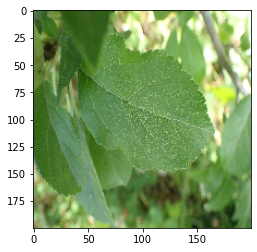

In [174]:
plt.imshow(nt[0].reshape(200,200,3))

AttributeError: 'numpy.ndarray' object has no attribute 'savetxt'

In [65]:
col_name = f"pixel_{1}"

In [66]:
col_name

'pixel_1'

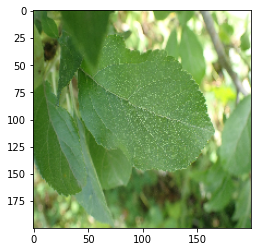

In [59]:
plt.imshow(img_and_label['imgs_arr'][0].reshape(200,200,3))

In [60]:
pd.DataFrame(img_and_label)

,imgs_arr,labels
0,"[0.49411768, 0.6156863, 0.31764707, 0.4156863,...",healthy
1,"[0.8117648, 0.7568628, 0.7137255, 0.8313726, 0...",scab frog_eye_leaf_spot complex
2,"[0.40000004, 0.5568628, 0.16862746, 0.38823533...",scab
3,"[0.5137255, 0.6666667, 0.34901962, 0.38823533,...",scab
4,"[0.16470589, 0.2392157, 0.0627451, 0.16078432,...",complex
...,...,...
18627,"[0.5176471, 0.48235297, 0.3137255, 0.47450984,...",healthy
18628,"[0.34901962, 0.43529415, 0.28627452, 0.4078431...",scab
18629,"[0.36862746, 0.5176471, 0.18431373, 0.36078432...",rust
18630,"[0.40000004, 0.6117647, 0.40784317, 0.3921569,...",scab frog_eye_leaf_spot


In [ ]:
plt.imshow(img_and_label)

In [20]:
img_train_ori = pd.read_csv("train_images_array_form.csv")

In [21]:
img_train_ori.head()

,Unnamed: 0,images_arr,labels
0,0,[0.49411768 0.6156863 0.31764707 ... 0.247058...,healthy
1,1,[0.8117648 0.7568628 0.7137255 ... 0.450980...,scab frog_eye_leaf_spot complex
2,2,[0.40000004 0.5568628 0.16862746 ... 0.376470...,scab
3,3,[0.5137255 0.6666667 0.34901962 ... 0.145098...,scab
4,4,[0.16470589 0.2392157 0.0627451 ... 0.160784...,complex


In [32]:
test = []
for img in img_train_ori['images_arr']:
    for num in img[1:-1].split():
        print(float(num))

0.49411768
0.6156863
0.31764707


ValueError: could not convert string to float: '...'

In [36]:
img_train_ori['images_arr'][0].split()[3]

'...'

In [20]:
def show_images(images, labels, len_picts=0):
    if len_picts == 0:
        print("masuk 1")
        fig, ax = plt.subplots(figsize=(10,10), nrows=len(images))
        for idx, image in enumerate(images):
            ax[idx].imshow(image)
            ax[idx].set_title(labels[idx])
            ax[idx].axis(False)
    else:
        print("masuk 2")  
        fig, ax = plt.subplots(figsize=(10,10), nrows=len_picts)
        for idx in range(len_picts):
            ax[idx].imshow(images[idx])
            ax[idx].set_title(labels[idx])
            ax[idx].axis(False)
    plt.show()

masuk 2


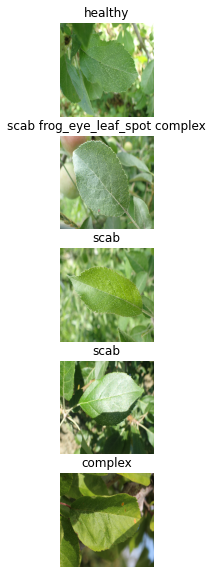

In [52]:
show_images(imgs_gpu, metadata_train.labels, 5)

In [77]:
# image flatten to store in df 

# flat_imgs_gpu = []
# for idx, img in enumerate(imgs_gpu):
#     flat_imgs_gpu.append(img.reshape(-1))

In [88]:
# new_df = pd.DataFrame({"images_arr": flat_imgs_gpu, "labels": metadata_train_ori.labels})

In [89]:
# new_df.to_csv("train_images_array_form.csv")

In [28]:
new = pd.read_csv("train_images_array_form.csv")